In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
from helper import laplace_solution, l2_norm, plot_3d

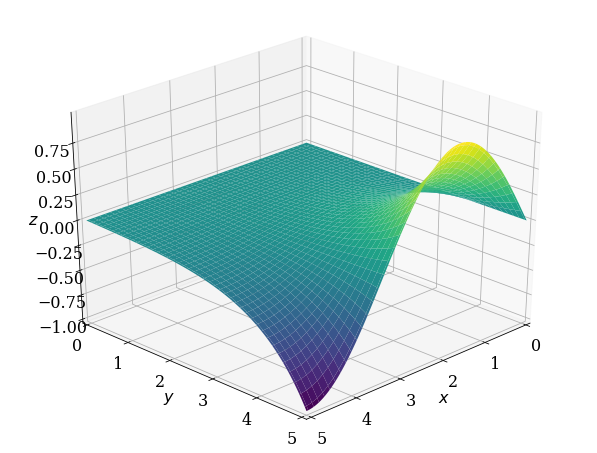

In [4]:
nx = 128
ny = 128
Lx = 5.0
Ly = 5.0
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)

x = numpy.linspace(0.0, Lx, num = nx)
y = numpy.linspace(0.0, Ly, num = ny)

p0 = numpy.zeros((ny, nx))
p0[-1, :] = numpy.sin(1.5 * numpy.pi * x / Lx)

p_exact = laplace_solution(x, y, Lx, Ly)
plot_3d(x, y, p_exact)

In [5]:
def laplace_2d_jacobi(p0, maxiter = 20000, rtol = 1e-6):
    p = p0.copy()
    diff = rtol + 1.0
    ite = 0
    conv = []
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        
        p[1:-1, 1:-1] = 0.25 * (pn[1:-1, :-2] + pn[1:-1, 2:] + 
                          pn[:-2, 1:-1] + pn[2:, 1:-1])
        
        p[1:-1, -1] = 0.25 * (2.0 * pn[1:-1, -2] + 
                              pn[2:, -1] + pn[:-2, -1])
        rdiff = numpy.sqrt(numpy.sum((p - pn)**2) / numpy.sum(pn**2))
        conv.append(rdiff)
        diff = l2_norm(p, pn)
        ite += 1
    return p, ite, diff, rdiff

In [6]:
def laplace_2d_jacobi_2for(p0, maxiter = 20000, rtol = 1e-6):
    p = p0.copy()
    diff = rtol + 1.0
    ite = 0
    conv = []
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                
                p[i, j] = 0.25 * (pn[j - 1, i] + pn[j, i - 1] + 
                                  pn[j, i + 1] + pn[j + 1, i])
        
        for j in range(1, ny - 1):
            p[j, -1] = 0.25 * (2.0 * pn[j, -2] + 
                               pn[j, -2] + pn[j +  1, -1])
            
        rdiff = numpy.sqrt(numpy.sum((p - pn)**2) / numpy.sum(pn**2))
        conv.append(rdiff)
        diff = l2_norm(p, pn)
        ite += 1
    return p, ite, diff, rdiff

In [7]:
p, ites, diff, conv = laplace_2d_jacobi(p0, maxiter = 20000, rtol = 1e-8)
print('Jacobi relaxation: {} iterations'.format(ites) + 
      'to reach a relative difference of {}'.format(diff))

Jacobi relaxation: 19993 iterationsto reach a relative difference of 9.998616841158966e-09


In [8]:
%%time
p, ites, conv, rdiff = laplace_2d_jacobi(p0, maxiter = 500, rtol = 1e-8)

CPU times: user 144 ms, sys: 4 ms, total: 148 ms
Wall time: 182 ms


In [9]:
%%time
p, ites, conv, rdiff = laplace_2d_jacobi_2for(p0, maxiter = 500, rtol = 1e-8)

CPU times: user 8.26 s, sys: 0 ns, total: 8.26 s
Wall time: 8.31 s


In [10]:
l2_norm(p, p_exact)

0.7441394877207048

In [11]:
def laplace_2d_gauss_seidel(p0, maxiter = 20000, rtol = 1e-6):
    ny, nx = p0.shape
    p = p0.copy()
    diff = rtol + 1.0
    ite = 0
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                p[j, i] = 0.25 * (p[j, i - 1] + p[j, i + 1] + 
                                  p[j - 1, i] + p[j + 1, i])
        for j in range(1, ny - 1):
            p[j, -1] = 0.25 * (2.0 * p[j, -2] + 
                               p[j - 1, -1] + p[j + 1, -1])
            
        diff = l2_norm(p, pn)
        ite += 1
    return p, ite, diff

In [12]:
import numba
from numba import jit

In [13]:
def fib_it(n):
    a, b = 1, 1
    for i in range(n - 2):
        a, b = b, a + b
    return b

In [14]:
%%timeit
fib_it(500000)

3.31 s ± 6.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
@jit
def fib_it(n):
    a, b = 1, 1
    for i in range(n - 2):
        a, b = b, a + b
    return b

In [16]:
%%timeit
fib_it(500000)

331 µs ± 2.03 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
print(numba.__version__)

0.38.1


In [37]:
@jit(nopython=True)
def laplace_2d_jacobi(p0, maxiter = 20000, rtol = 1e-6):
    p = p0.copy()
    diff = rtol + 1.0
    ite = 0
    conv = []
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        
        p[1:-1, 1:-1] = 0.25 * (pn[1:-1, :-2] + pn[1:-1, 2:] + 
                          pn[:-2, 1:-1] + pn[2:, 1:-1])
        
        p[1:-1, -1] = 0.25 * (2.0 * pn[1:-1, -2] + 
                              pn[2:, -1] + pn[:-2, -1])
        rdiff = numpy.sqrt(numpy.sum((p - pn)**2) / numpy.sum(pn**2))
        conv.append(rdiff)
        diff = rdiff
        ite += 1
    return p, ite, conv, rdiff

In [38]:
p, ites, conv_jacobi, conv = laplace_2d_jacobi(p0, maxiter = 20000, rtol = 1e-8)
print('Jacobi relaxation: {} iterations'.format(ites) + 
      'to reach a relative difference of {}'.format(diff))

Jacobi relaxation: 19993 iterationsto reach a relative difference of 9.998616841158966e-09


In [20]:
%%timeit
laplace_2d_jacobi(p0, maxiter=20000, rtol = 1e-8)

3.08 s ± 4.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
@jit(nopython=True)
def laplace_2d_gauss_seidel(p0, maxiter = 20000, rtol = 1e-6):
    ny, nx = p0.shape
    p = p0.copy()
    diff = rtol + 1.0
    ite = 0
    conv = []
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                p[j, i] = 0.25 * (p[j, i - 1] + p[j, i + 1] + 
                                  p[j - 1, i] + p[j + 1, i])
        for j in range(1, ny - 1):
            p[j, -1] = 0.25 * (2.0 * p[j, -2] + 
                               p[j - 1, -1] + p[j + 1, -1])
            
        diff = numpy.sqrt(numpy.sum((p - pn)**2) / numpy.sum(pn**2))
        conv.append(diff)
        ite += 1
    return p, ite, conv

In [22]:
p, ites, conv_gs = laplace_2d_gauss_seidel(p0, maxiter = 20000,
                                          rtol = 1e-8)
print('Gauss-Seidel relaxation: {} iterations '.format(ites) +
      'to reach a relative difference of {}'.format(conv_gs[-1]))

Gauss-Seidel relaxation: 13939 iterations to reach a relative difference of 9.997635652064425e-09


In [23]:
%%timeit
laplace_2d_gauss_seidel(p0, maxiter = 20000, rtol = 1e-8)

2.46 s ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
@jit(nopython=True)
def laplace_2d_sor(p0, omega, maxiter = 20000, rtol = 1e-6):
    ny, nx = p0.shape
    p = p0.copy()
    conv = []
    diff = rtol + 1.0
    ite = 0
    while diff > rtol and ite < maxiter: 
        pn = p.copy()
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                p[j, i] = ((1.0 - omega) * p[j, i] + 
                          omega * 0.25 * (p[j, i - 1] + p[j, i + 1] + 
                                         p[j - 1, i] + p[j + 1, i]))
        for j in range(1, ny - 1):
            p[j, -1] = 0.25 * (2.0 * p[j, -2] + p[j - 1, -1] + p[j + 1, -1])
            
        diff = numpy.sqrt(numpy.sum((p - pn)**2) / numpy.sum(pn**2))
        conv.append(diff)
        ite += 1
        
    return p, ite, conv

In [25]:
omega = 1.0
p, ites, conv_sor = laplace_2d_sor(p0, omega,
                                   maxiter=20000, rtol=1e-8)
print('SOR (omega={}): {} iterations '.format(omega, ites) +
      'to reach a relative difference of {}'.format(conv_sor[-1]))

SOR (omega=1.0): 13939 iterations to reach a relative difference of 9.997635652064425e-09


In [32]:
omega = 1.5
p, ites, conv_sor = laplace_2d_sor(p0, omega,
                                   maxiter=20000, rtol=1e-8)
print('SOR (omega={}): {} iterations '.format(omega, ites) +
      'to reach a relative difference of {}'.format(conv_sor[-1]))

SOR (omega=1.5): 7108 iterations to reach a relative difference of 9.991011447055284e-09


In [27]:
%%timeit
laplace_2d_sor(p0, omega, maxiter = 20000, rtol = 1e-8)

1.38 s ± 606 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
omega = 2 / (1 + numpy.pi / nx) #largest omega for square domains
p, ites, conv_opt_sor = laplace_2d_sor(p0, omega,
                                   maxiter=20000, rtol=1e-8)
print('SOR (omega={}): {} iterations '.format(omega, ites) +
      'to reach a relative difference of {}'.format(conv_sor[-1]))

SOR (omega=1.9520885389597442): 1110 iterations to reach a relative difference of 9.991011447055284e-09


In [34]:
%%timeit
laplace_2d_sor(p0, omega, maxiter = 20000, rtol = 1e-8)

217 ms ± 416 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
l2_norm(p, p_exact)

7.792743355064513e-05

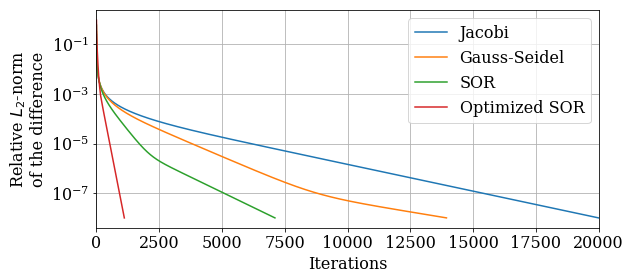

In [39]:
pyplot.figure(figsize=(9.0, 4.0))
pyplot.xlabel('Iterations')
pyplot.ylabel('Relative $L_2$-norm\nof the difference')
pyplot.grid()
pyplot.semilogy(conv_jacobi, label='Jacobi')
pyplot.semilogy(conv_gs, label='Gauss-Seidel')
pyplot.semilogy(conv_sor, label='SOR')
pyplot.semilogy(conv_opt_sor, label='Optimized SOR')
pyplot.legend()
pyplot.xlim(0, 20000);